# Food 101 Challenge Problem

*by Andrew McCarthy*

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *

import json

In [3]:
#define paths
food101 = Path('/DATA/food-101/')
images = food101/'images'
torch.backends.cudnn.benchmark = True

In [4]:
def get_src(valid_pct=0.2, filter_pct=None):
    src = ImageItemList.from_folder(images)
    if not filter_pct is None:
        src = src.filter_by_rand(filter_pct)
    src = src.random_split_by_pct(valid_pct).label_from_folder()
    return src

def get_data(src, bs, size, tfms=get_transforms()):
    data = (src
            .transform(tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [5]:
src = get_src()
data = get_data(src, 64, 224)

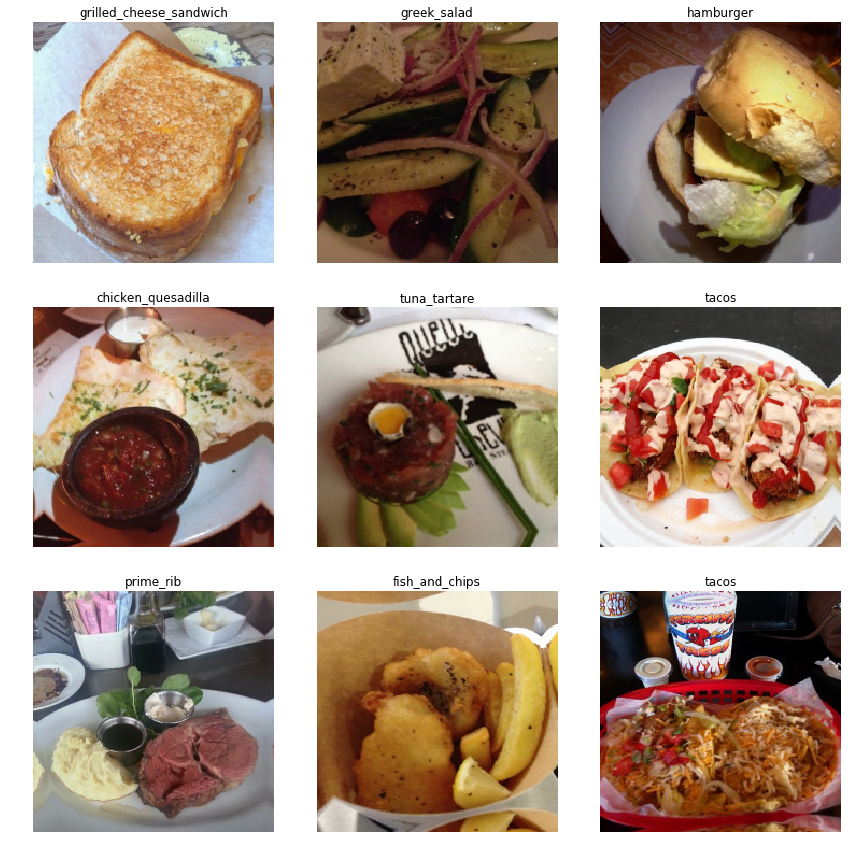

In [7]:
data.show_batch(rows=3, figzie=(7,8))

In [21]:
data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
#initial cnn with no extra transformations
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate], path="localdir")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02


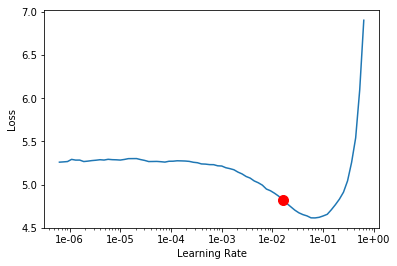

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(4, 1.58E-02)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.469784,2.391473,0.401040,0.598960
2,1.933056,1.867205,0.532426,0.467574
3,1.463995,2.316139,0.686683,0.313317
4,1.240877,1.039406,0.729604,0.270396


In [9]:
learn.save('stage-001')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05


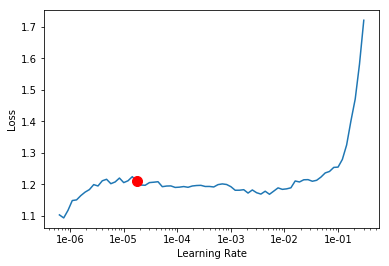

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.unfreeze()
learn.fit_one_cycle(4, 1.74E-05)

epoch,train_loss,valid_loss,accuracy,error_rate
1,1.181740,1.022995,0.731634,0.268366
2,1.093075,0.960027,0.749604,0.250396
3,1.044886,0.943544,0.759604,0.240396
4,0.947885,0.978362,0.762228,0.237772


In [12]:
learn.save('stage-002')

In [ ]:
#find most commonly mistaken images
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, path=images)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


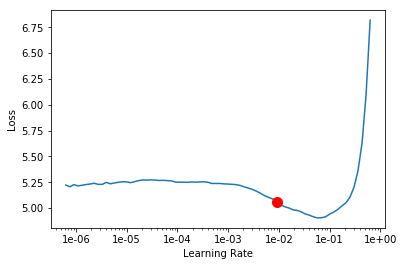

In [5]:
#second cnn with minor transformations and larger image sizes
xtra_tfms = [jitter(magnitude=0.008,p=0.5), squish(scale = 1.33)]
tfms = get_transforms(flip_vert=False,
                      do_flip=True,
                      xtra_tfms=xtra_tfms)
src = get_src()
data=get_data(src, 64, 300, tfms)
#cnn with transformations added to dataset
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate], path="localdir").to_fp16(loss_scale=256).mixup()
learn.lr_find()
learn.recorder.plot()

In [6]:
learn.fit_one_cycle(8, 9.12E-03)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.927966,1.822219,0.573020,0.426980
2,2.934594,2.010067,0.500347,0.499653
3,2.841593,1.734876,0.584406,0.415594
4,2.691772,1.497451,0.641287,0.358713
5,2.563258,1.354570,0.683069,0.316931
6,2.454580,1.198396,0.724752,0.275248
7,2.329282,1.125408,0.748762,0.251238
8,2.328475,1.101105,0.752525,0.247475


In [7]:
learn.save('stage-103')

In [8]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05


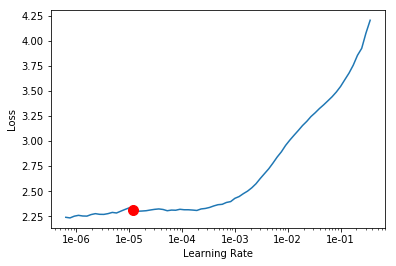

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(4, 1.20E-05)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.311784,1.090844,0.757525,0.242475
2,2.273375,1.054889,0.765990,0.234010
3,2.258015,1.024107,0.774852,0.225149
4,2.208987,1.017791,0.775495,0.224505


In [11]:
learn.save('stage-104')

In [12]:
#tta to improve results
learn.to_fp32()
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.7933)

In [13]:
learn.save('stage-105')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


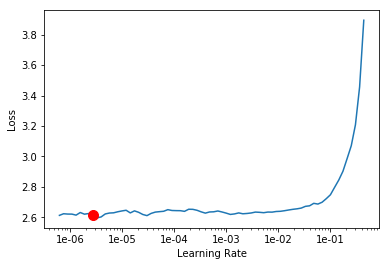

In [14]:
#third cnn with more transformations
xtra_tfms = [jitter(magnitude=0.01,p=0.5), squish(scale = 0.66)]
tfms = get_transforms(flip_vert=False,
                      do_flip=True,
                      max_rotate=30.0,
                      max_zoom=1.5,
                      max_lighting=0.4,
                      max_warp=0.4,
                      xtra_tfms=xtra_tfms)
src = get_src()
data=get_data(src, 64, 350, tfms)
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate], path="localdir").load('stage-105').to_fp16(loss_scale=256).mixup()
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, 2.75E-06)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.636186,0.964216,0.790049,0.209950
2,2.645525,0.955979,0.791386,0.208614
3,2.651377,0.958152,0.791436,0.208564
4,2.667558,0.954133,0.793762,0.206238


In [16]:
learn.save('stage-206')

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


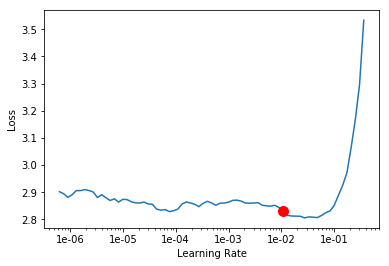

In [18]:
#fourth cnn with larger image sizes
data=get_data(src, 64, 450, tfms)
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate], path="localdir").load('stage-206').to_fp16(loss_scale=256).mixup()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, 1.10E-02)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.894873,1.462822,0.644059,0.355941
2,2.867280,1.335407,0.668960,0.331040
3,2.621505,1.124630,0.739257,0.260743
4,2.507720,1.030402,0.765000,0.235000


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


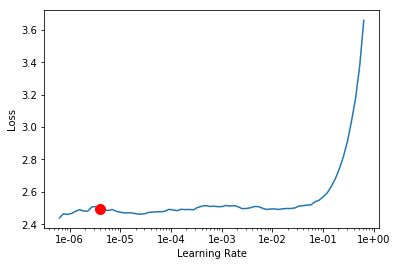

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4, 3.98E-06)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.486877,1.029826,0.765990,0.234010
2,2.519680,1.032497,0.765297,0.234703
3,2.493732,1.033604,0.765495,0.234505
4,2.497869,1.033631,0.765941,0.234059


In [22]:
learn.save('stage-307')

In [24]:
#retrieve new images for worst performing classes
from icrawler.builtin import GoogleImageCrawler

images = ['pulled pork sandwich', 'pho', 'cheesecake', 'hamburger', 'lobster roll sandwich']
classes = ['pulled_pork_sandwich', 'pho', 'cheesecake', 'hamburger', 'lobster_roll_sandwich']

for x in range(0, 4):
    google_crawler = GoogleImageCrawler(storage={'root_dir': '/DATA/food-101/images/' + classes[x]})
    google_crawler.crawl(keyword=images[x], max_num=50)

2019-02-21 01:10:37,611 - INFO - icrawler.crawler - start crawling...
2019-02-21 01:10:37,612 - INFO - icrawler.crawler - starting 1 feeder threads...
2019-02-21 01:10:37,613 - INFO - feeder - thread feeder-001 exit
2019-02-21 01:10:37,613 - INFO - icrawler.crawler - starting 1 parser threads...
2019-02-21 01:10:37,616 - INFO - icrawler.crawler - starting 1 downloader threads...
2019-02-21 01:10:38,233 - INFO - parser - parsing result page https://www.google.com/search?q=pulled+pork+sandwich&ijn=0&start=0&tbs=&tbm=isch
2019-02-21 01:10:38,556 - INFO - downloader - image #1	https://food.fnr.sndimg.com/content/dam/images/food/fullset/2010/6/8/2/FNM_070110-Try-This-at-Home-012_s4x3.jpg.rend.hgtvcom.826.620.suffix/1371592877408.jpeg
2019-02-21 01:10:38,642 - INFO - downloader - image #2	https://food.fnr.sndimg.com/content/dam/images/food/fullset/2012/10/2/2/FNM_110112-Slow-Cooker-Pulled-Pork-Sandwiches-Recipe_s4x3.jpg.rend.hgtvcom.406.305.suffix/1504040037237.jpeg
2019-02-21 01:10:39,051 -

2019-02-21 01:10:58,266 - INFO - downloader - image #48	https://assets.marthastewart.com/styles/wmax-1500/d43/mla101624burger_0107_pulled_pork_sandwiches/mla101624burger_0107_pulled_pork_sandwiches_sq.jpg?itok=30Rr8uJw
2019-02-21 01:10:58,468 - INFO - downloader - image #49	https://images.eatthismuch.com/site_media/img/57157_erin_m_9a5fff83-b1a0-4d3d-a0c6-f07a336ac936.png
2019-02-21 01:10:58,642 - INFO - downloader - image #50	https://www.tasteofhome.com/wp-content/uploads/2017/10/Tangy-Pulled-Pork-Sandwiches_EXPS_HSCBZ16_23772_B07_29_2b-1-696x696.jpg
2019-02-21 01:10:58,909 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to exit
2019-02-21 01:10:58,910 - INFO - downloader - thread downloader-001 exit
2019-02-21 01:10:59,641 - INFO - icrawler.crawler - Crawling task done!
2019-02-21 01:10:59,643 - INFO - icrawler.crawler - start crawling...
2019-02-21 01:10:59,644 - INFO - icrawler.crawler - starting 1 feeder threads...
2019-02-21 01:10:59,644 - IN

2019-02-21 01:11:15,824 - INFO - downloader - image #45	https://images-na.ssl-images-amazon.com/images/I/917j9D%2BbJmL.jpg
2019-02-21 01:11:16,021 - INFO - downloader - image #46	https://d1doqjmisr497k.cloudfront.net/-/media/mccormick-us/recipes/simply-asia/p/800/pho_meatball_soup_800x800.ashx?vd=20180710T052811Z&hash=955A9C5DDDB0619B245ABE27FAEB584160C34D9A
2019-02-21 01:11:16,221 - INFO - downloader - image #47	https://d3awvtnmmsvyot.cloudfront.net/api/file/onSBfksVRoGvejPBA0YO
2019-02-21 01:11:16,726 - INFO - downloader - image #48	https://cultureatz.com/wp-content/uploads/2018/02/Vietnamese-Beef-Pho-Play-Soup-with-Coffee.jpg
2019-02-21 01:11:18,177 - INFO - downloader - image #49	https://halongbayphoandgrill.com/wp-content/uploads/2017/07/pho-dac-biet-Ha-Long-Bay.jpg
2019-02-21 01:11:18,446 - INFO - downloader - image #50	https://steamykitchen.com/wp-content/uploads/2008/02/vietnamese-pho-recipe-2.jpg
2019-02-21 01:11:18,742 - INFO - downloader - downloaded images reach max num, th

2019-02-21 01:11:30,785 - INFO - downloader - image #40	https://www.biggerbolderbaking.com/wp-content/uploads/2018/04/Japanese-Cheesecake-Thumnail-final-.jpg
2019-02-21 01:11:30,961 - INFO - downloader - image #41	https://www.onceuponachef.com/images/2017/12/NY-Cheesecake-760x574.jpg
2019-02-21 01:11:31,129 - INFO - downloader - image #42	https://www.thereciperebel.com/wp-content/uploads/2018/05/no-bake-white-chocolate-raspberry-cheesecake-www.thereciperebel.com-600-15-500x375.jpg
2019-02-21 01:11:31,168 - INFO - downloader - image #43	https://assets.kraftfoods.com/recipe_images/Our-Best-Cheesecake-3074.jpg
2019-02-21 01:11:31,310 - INFO - downloader - image #44	https://ichef.bbci.co.uk/food/ic/food_16x9_832/recipes/lemoncheesecake_65665_16x9.jpg
2019-02-21 01:11:31,721 - INFO - downloader - image #45	https://thestayathomechef.com/wp-content/uploads/2018/09/New-York-Cheesecake-3-2.jpg
2019-02-21 01:11:31,916 - INFO - downloader - image #46	https://cdn1.harryanddavid.com/wcsstore/HarryA

2019-02-21 01:11:48,143 - INFO - downloader - image #35	https://visualsonline.cancer.gov/retrieve.cfm?imageid=2518&dpi=300&fileformat=jpg
2019-02-21 01:11:48,828 - INFO - downloader - image #36	http://www.hamburgerhamlet.com/wp-content/uploads/2014/11/the-hamburger-hamlet-sherman-oaks-34.jpg
2019-02-21 01:11:49,122 - INFO - downloader - image #37	https://s3-us-east-2.amazonaws.com/thesaltymarshmallow/wp-content/uploads/2018/07/10080911/homemade-hamburger-helper1.jpg
2019-02-21 01:11:49,331 - INFO - downloader - image #38	https://cdn-image.myrecipes.com/sites/default/files/styles/4_3_horizontal_-_900x675/public/classic-burgers-u.jpg?itok=jy7-zE2F
2019-02-21 01:11:49,518 - INFO - downloader - image #39	https://cf-images.us-east-1.prod.boltdns.net/v1/static/1033249144001/52b8c209-17a4-4045-91d9-d7155af55561/dd1ec82e-e77d-4b89-9d04-cd0bbaf7e29d/1280x720/match/image.jpg
2019-02-21 01:11:51,255 - INFO - downloader - image #40	http://www.magimix.com/files/rec_22546/in_uk_hamburger.jpg
2019-02

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


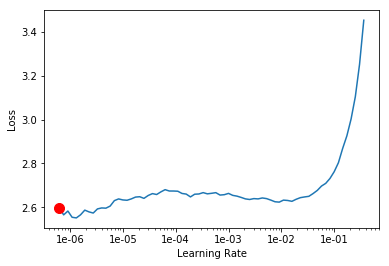

In [25]:
#fifth cnn after new images from the worst performing classes have been added
data=get_data(src, 64, 350, tfms)
learn = create_cnn(data, models.resnet50, metrics=[accuracy, error_rate], path="localdir").load('stage-206').to_fp16(loss_scale=256).mixup()
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, 6.31E-07)

epoch,train_loss,valid_loss,accuracy,error_rate
1,2.664837,0.957293,0.792079,0.207921
2,2.631889,0.951406,0.793515,0.206485
3,2.651613,0.950134,0.794010,0.205990
4,2.638551,0.954235,0.793416,0.206584


In [27]:
learn.to_fp32()
log_preds, y = learn.TTA()
prob = np.exp(log_preds)
accuracy(log_preds, y)

tensor(0.7902)